In [1]:
import pandas as pd
import pickle
import numpy as np

p = r'../data/IMDB_Dataset.csv'
df = pd.read_csv(p)
print(df.shape)
print(df['sentiment'].value_counts())

# 5만개를 shuffle해서 70%는 train으로
ratio = 0.7
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df_train = df.iloc[:int(ratio * len(df))]
df_train['sentiment'] = [1 if label =='positive' else 0 for label in df_train['sentiment']]
print(df_train.shape)
print(df_train['sentiment'].value_counts())
df_test = df.iloc[int(ratio * len(df)):]
df_test['sentiment'] = [1 if label =='positive' else 0 for label in df_test['sentiment']]
print(df_test.shape)
print(df_test['sentiment'].value_counts())

df_train.to_csv(r'../data/IMDB_Dataset-train.csv', index=False)
df_test.to_csv(r'../data/IMDB_Dataset-test.csv', index=False)
df_train.head()

(50000, 2)
positive    25000
negative    25000
Name: sentiment, dtype: int64
(35000, 2)
0    17515
1    17485
Name: sentiment, dtype: int64
(15000, 2)
positive    7515
negative    7485
Name: sentiment, dtype: int64


C:\Users\SHIN-DESKTOP\AppData\Local\Temp\ipykernel_12904\3635148756.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sentiment'] = [1 if label =='positive' else 0 for label in df_train['sentiment']]


KeyboardInterrupt: 

In [21]:
from collections import Counter
from nltk.corpus import stopwords
import re


def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val, vocab=19998):
    word_list = []

    print("create vocab")
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        sent = sent.replace(r"<br />",' ')
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    print("sorting")
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:vocab]
    # creating a dict
    onehot_dict = {w:i+1 for i, w in enumerate(corpus_)}

    print('tokenizing')
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = y_train
    encoded_test = y_val

    return final_list_train, encoded_train, final_list_test, encoded_test,onehot_dict

x_train,y_train,x_test,y_test,vocab = tokenize(x_train=df_train['review'],
                                               y_train=df_train['sentiment'],
                                               x_val=df_test['review'],
                                               y_val=df_test['sentiment'])

create vocab
sorting
tokenizing


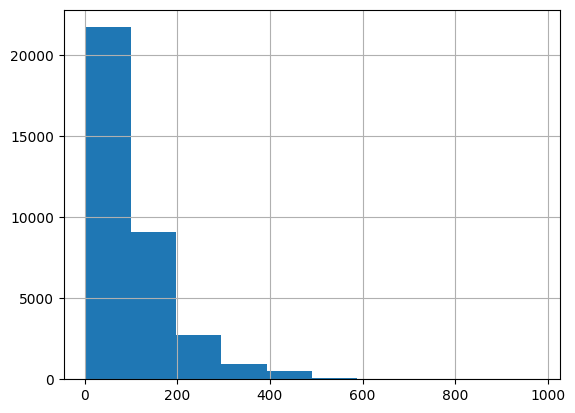

count    35000.000000
mean       110.063571
std         81.577115
min          3.000000
25%         60.000000
50%         82.000000
75%        133.000000
max        977.000000
dtype: float64

In [22]:
import matplotlib.pyplot as plt

rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [26]:
max_len = 500

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

x_train_pad = padding_(x_train,max_len)
x_test_pad = padding_(x_test,max_len)
print(len(x_train_pad), len(y_train))
print(len(x_test_pad), len(y_test))
print(len(x_train_pad[0]))

35000 35000
15000 15000
500


In [27]:
train_tokenized_idx = np.array(x_train_pad)
train_labels_np = np.array(y_train)
train_data = (train_tokenized_idx, train_labels_np)
print(train_tokenized_idx.shape)
print(train_labels_np.shape)

print('now dumping pickle')
with open(file='IMDB_Dataset-train_sample.pkl', mode='wb') as f:
    pickle.dump(train_data, f)

(35000, 500)
(35000,)
now dumping pickle


In [28]:
test_tokenized_idx = np.array(x_test_pad)
test_labels_np = np.array(y_test)
test_data = (test_tokenized_idx, test_labels_np)
print(test_tokenized_idx.shape)
print(test_labels_np.shape)

print('now dumping test pickle')
# with open(file='ag_test.pkl', mode='wb') as f:
with open(file='IMDB_Dataset-test_sample.pkl', mode='wb') as f:
    pickle.dump(test_data, f)

(15000, 500)
(15000,)
now dumping test pickle
